In [ ]:
# default_exp datasets

# Dataset Class

This class reads in a dataset and does the necessary preprocessing for a pytorch model.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# EXPORT
#from torchvision import datasets, transforms
import os, sys
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

In [ ]:
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200'

In [ ]:
files = glob(os.path.join(dataDirec,'v','*.npz'))
files

['/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/16_3_156.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/5_3_53.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/2_0_73.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/6_2_112.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/13_0_23.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/10_1_108.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/12_4_146.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/15_3_17.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/6_4_180.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/5_3_137.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/4_3_47.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/9_1_132.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/3_0_67.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/15_1_0.npz',
 '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v/12_0_37.npz',
 '/data/mantaFlowSim/data/s

In [ ]:
# EXPORT
def loadfile(fn):
    A = np.load(fn)
    X = A['x'].astype('float32')
    X = np.rollaxis(X,-1)
    y = A['y'].astype('float32')
    return X,y

In [ ]:
X,y = loadfile(files[100])
X.shape, y.shape

((2, 128, 96), (3,))

In [ ]:
# EXPORT
class MantaFlowDataset(Dataset):
    def __init__(self, 
                 dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=np.infty,transform=None, reverseXY=False, preprocess=True, AE=False): 
        if type(dataDirec) == list:
            self.files = dataDirec
        else:
            self.files = glob(os.path.join(dataDirec,'*.npz'))
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.reverseXY = reverseXY
        self.AE = AE
        self.data = []
 
        if numToKeep < len(self.files):
            self.files = self.files[:numToKeep]
        for f in tqdm(self.files):
            X,y = self.loadfile(f)
            
            if preprocess:
                X,y = self.preprocessFcn(X,y)
                
            if reverseXY:
                self.data.append((y,X))
            else:
                self.data.append((X,y))

    def loadfile(self,fn):
        A = np.load(fn)
        X = A['x'].astype('float32')
        X = np.rollaxis(X,-1)
        y = A['y'].astype('float32')
        return X,y

    def preprocessFcn(self,X,y):
        x_range = 11.953
        X /= x_range
        y_range = [[0.2, 0.8], [0.04, 0.12], [0.0, 199.0]]
        for i, ri in enumerate(y_range):
            y[i] = (y[i]-ri[0]) / (ri[1]-ri[0]) * 2 - 1
        return X,y
    
    def __len__(self):
        return len(self.data)

    def plot(self,idx,savefig=False):
        X, label  = self.data[idx]
        if self.reverseXY:
            X = label
            
        plt.figure(figsize=(20,10))
        
        plt.subplot(211)
        fn = self.files[idx].replace('.npz','')
        title = '{} channel 0'.format(fn)
        plt.title(title)
        plt.imshow(X[0][::-1])
        plt.colorbar()
        
        plt.subplot(212)
        title = '{} channel 1'.format(fn)
        plt.title(title)
        plt.imshow(X[1][::-1])
        plt.colorbar()
        
        if savefig:
            title = title.replace(' ','_') + '.png'
            plt.savefig(title, dpi=300)
            plt.close()
        else:
            plt.show()

    def __getitem__(self, idx):
        X, y  = self.data[idx]
        if self.transform:
            X = self.transform(X)
        if self.AE:
            return X, X # looks crazy, but it's dirty fix to allow lr_finder to work 
        return X, y

In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=100)

100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v')

  9%|▊         | 1824/21000 [00:46<12:19, 25.95it/s]

KeyboardInterrupt: 

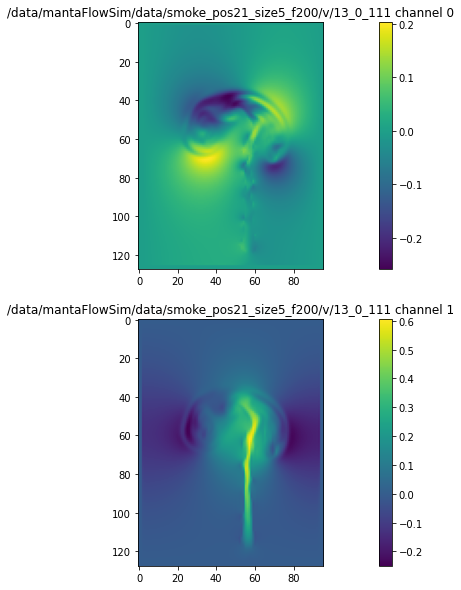

In [ ]:
M.plot(54)

In [ ]:
M.plot(54,savefig=True)

In [ ]:
bz = 16
dataLoader = DataLoader(M,batch_size=bz,shuffle=True)

In [ ]:
X,y = next(iter(dataLoader))

In [ ]:
X.shape
X.dtype

torch.float32

In [ ]:
y.shape
y.dtype

torch.float32

In [ ]:
# M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
#                  numToKeep=np.infty)

In [ ]:
dataLoader = DataLoader(M,batch_size=bz,shuffle=True)

In [ ]:
cnt = 1
for batch in dataLoader:
    cnt += 1

In [ ]:
cnt

8

In [ ]:
MfromList = MantaFlowDataset(files,numToKeep=100)

100%|██████████| 100/100 [00:00<00:00, 372.33it/s]


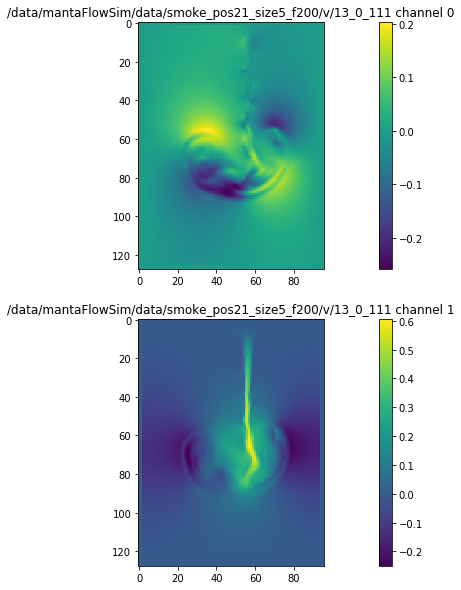

In [ ]:
MfromList.plot(54)

In [ ]:
MfromList = MantaFlowDataset(files,numToKeep=100,reverseXY=True)

100%|██████████| 100/100 [00:00<00:00, 188.34it/s]


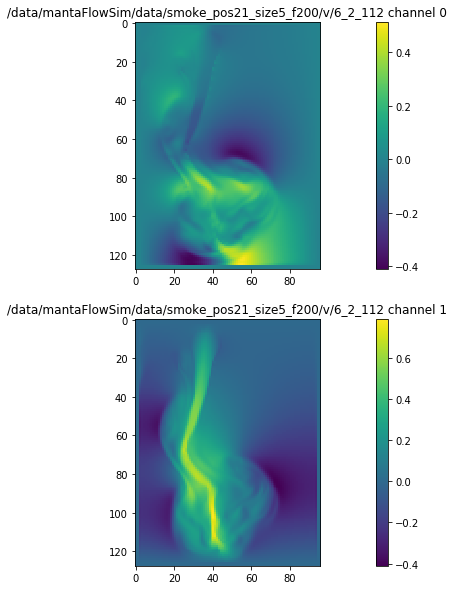

In [ ]:
MfromList.plot(3)

In [ ]:
dataLoader = DataLoader(MfromList,batch_size=bz)

In [ ]:
a,b = next(iter(dataLoader))
a.shape
b.shape

torch.Size([16, 2, 128, 96])

In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=100, AE=True)

100%|██████████| 100/100 [00:00<00:00, 430.47it/s]


In [ ]:
A,B = M[10]

In [ ]:
X,p = A
X.shape, p.shape

((128, 96), (128, 96))

In [ ]:
B.shape

(2, 128, 96)

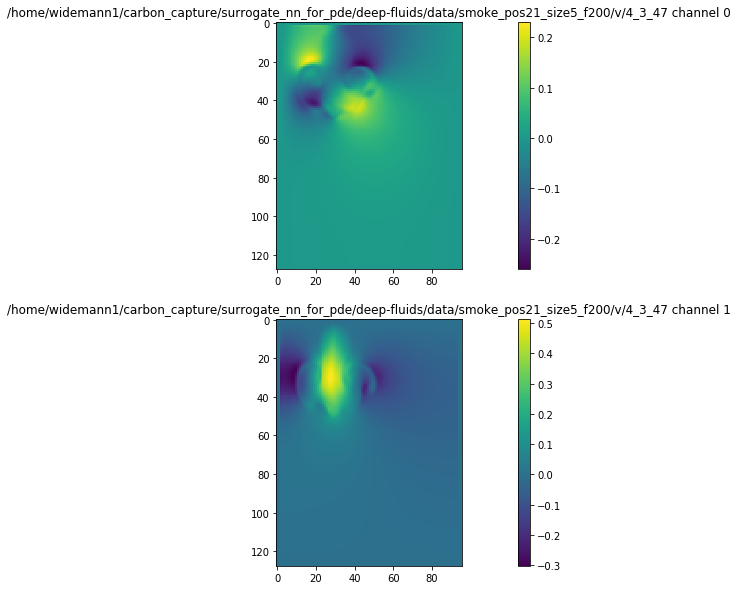

In [ ]:
M.plot(10)

In [ ]:
# EXPORT
import os
from glob import glob

def getSingleSim(sim,
                 dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 simLen=200):
    if type(dataDirec) == str:
        data = glob(os.path.join(dataDirec,'*.npz'))
    else:
        data = dataDirec
    data = sorted(data)
    out = data[sim*simLen:(sim+1)*simLen]
    order = []
    for fn in out:
        a = os.path.basename(fn).replace('.npz','').split('_')
        order.append(int(a[2]))
    sorted_idx = np.argsort(order)
    out = [out[i] for i in sorted_idx]
    return out


def createMantaFlowTrainTest(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                            simLen=200,
                            testSplit=.1,
                            seed=1234):
    data = glob(os.path.join(dataDirec,'*.npz'))
    data = sorted(data)
    numSims = len(data)//simLen
    numTestSamples = int(np.round(testSplit*numSims))
    np.random.seed(seed)
    perm = np.random.permutation(numSims)
    testSims = perm[:numTestSamples]
    trainSims = perm[numTestSamples:]
    
    def _getSimFrames(data, sim=0,simLen=200):
        out = data[sim*simLen:(sim+1)*simLen]
        order = []
        for fn in out:
            a = os.path.basename(fn).replace('.npz','').split('_')
            order.append(int(a[2]))
        sorted_idx = np.argsort(order)
        out = [out[i] for i in sorted_idx]
        return out
    
    def _buildDataset(simData, sims, simLen):
        data = []
        for i in sims:
            sim = _getSimFrames(simData, i, simLen)
            data.append(sim)
        data = [i for sublist in data for i in sublist]
        return data
    
    testData = _buildDataset(data, testSims, simLen)
    trainData = _buildDataset(data, trainSims, simLen)
    return trainData, testData

In [ ]:
tr, te = createMantaFlowTrainTest()
te

['/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_0.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_1.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_2.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_3.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_4.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_5.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_6.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_7.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/15_2_8.npz',
 '/home/widemann1/c

In [ ]:
singleTestSim = getSingleSim(sim=5)
singleTestSim

['/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_0.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_1.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_2.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_3.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_4.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_5.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_6.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_7.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/10_0_8.npz',
 '/home/widemann1/c

In [ ]:
singleTestSim = getSingleSim(sim=5,dataDirec=te)
singleTestSim

['/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_0.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_1.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_2.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_3.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_4.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_5.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_6.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_7.npz',
 '/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v/20_2_8.npz',
 '/home/widemann1/c

In [ ]:
MantaFlowDataset(tr,numToKeep=1000)

100%|██████████| 1000/1000 [01:28<00:00, 11.29it/s]
